In [31]:
from minio import Minio
from minio.error import ResponseError
import boto3

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
with open("config.json", "r") as f:
    config = json.load(f)

In [3]:
feedback_df = pd.read_excel("feedback_sheet.xls")

In [4]:
has_feedback = -feedback_df[["Axle Event", "Odo Algo Issue", "Speed Estimation"]].isnull().any(axis=1)

In [5]:
feedback_df = feedback_df[has_feedback]

In [6]:
feedback_df["Axle Event"] = feedback_df["Axle Event"].str.lower()
feedback_df["Axle Event"] = feedback_df["Axle Event"].map({'unlikely':0, 
                                                           'maybe':1, 
                                                           'likely':2})

feedback_df["Odo Algo Issue"] = feedback_df["Odo Algo Issue"].map({'no':0, 
                                                                       'unlikely':1, 
                                                                       'likely':2})

feedback_df["Speed Estimation"] = feedback_df["Speed Estimation"].map({'Possible underestimation':-1, 
                                                                           'ok':0,
                                                                           'Possible overestimation':1})

In [7]:
# feedback_df[feedback_df["vehicleid"] == 4018].head()
feedback_df.head()

,timestamp,vehicleid,score,expert label,Axle Event,Odo Algo Issue,Speed Estimation,comment
20,2020/02/24 06:50:20977000,4018,-0.727133,NaN,0,2,1,Assuming this is the false slide in freight mi...
21,2020/03/03 05:53:40159000,4018,-0.715473,NaN,2,2,1,The first event looks like an undetected dual ...
22,2020/03/13 04:48:19683000,4018,-0.710113,NaN,2,1,1,Algo reaction to these slide events is a sligh...
23,2020/03/12 03:56:26017000,4018,-0.708628,NaN,0,2,1,Assuming this is the false slide in freight mi...
24,2020/03/17 07:01:51140000,4018,-0.677999,NaN,2,1,0,dual axle slip. Speed estimation looks good.


In [8]:
minioClient = Minio(config["minio_config"]["endpoint_url"].replace("http://","").rstrip("/"),
                    access_key=config["minio_config"]["aws_access_key_id"],
                    secret_key=config["minio_config"]["aws_secret_access_key"],
                    secure=False)

In [9]:
INPUT_BUCKET_NAME = "odometryclassification"

In [10]:
def build_events_list():
    # construct list of files in storage
    ll = minioClient.list_objects(INPUT_BUCKET_NAME, prefix="events1min/", recursive=True)
    ll = [e.object_name for e in ll if e.object_name.endswith(".pkl")]
    return ll

In [11]:
def build_filename_from_timestamp_vid(timestamp_str, vid_str):
    date_str, time_str = timestamp_str.split()
    date_str = date_str.replace("/", "-")
    time_str = time_str.replace(":", "-")
    datetime_str = "--".join([date_str, time_str])
    return f"{vid_str}_{datetime_str}.pkl"

In [12]:
df_features = pd.read_csv("features1min.csv", index_col=0)

In [13]:
df_features.head(3)

,axle1_minus_train_speed_min,axle1_minus_train_speed_max,axle1_minus_train_speed_mean,axle1_minus_train_speed_std,axle1_minus_train_speed_median,axle1_acc_min,axle1_acc_max,axle1_acc_mean,axle1_acc_std,axle1_acc_median,...,axle1_minus_axle2_integral,axle1_minus_axle2_integral_pos,axle1_minus_axle2_integral_neg,axle1_minus_train_integral,axle1_minus_train_integral_pos,axle1_minus_train_integral_neg,axle2_minus_train_integral,axle2_minus_train_integral_pos,axle2_minus_train_integral_neg,is_nominal
4005_2020-02-04--07-52-13755000,-18,1,-4.016529,5.740185,0.0,-2.0,1.0,-0.175000,0.784969,0.0,...,5.5,6.5,0.0,-243.0,6.0,-249.0,-243.0,26.0,-2254.5,False
4018_2020-02-25--06-58-04567000,-17,0,-4.090909,5.165591,-1.0,-2.0,0.0,-0.583333,0.705123,0.0,...,4.5,5.0,0.0,-247.5,0.0,-247.5,-247.5,0.0,-252.0,False
4018_2020-03-16--04-49-06952000,-24,0,-6.942149,7.762407,-4.0,-2.0,1.0,-0.333333,0.714006,0.0,...,-3.5,0.0,-17.5,-420.0,0.0,-840.0,-420.0,7.5,-418.0,False


In [14]:
matched_indices = list()
feedbacks = list()

for i, row in feedback_df.iterrows():
    event_filename = build_filename_from_timestamp_vid(row["timestamp"], row["vehicleid"])
    
    matched_indices.append([i for i in df_features.index if event_filename.rstrip(".pkl") in i][0])

    feedback = feedback_df[(feedback_df["timestamp"] == row["timestamp"]) & 
                           (feedback_df["vehicleid"] == row["vehicleid"])][["Axle Event", "Odo Algo Issue", "Speed Estimation"]].values.ravel()
    
    feedbacks.append(feedback)

In [15]:
labels = pd.DataFrame(feedbacks, columns=["Axle Event", "Odo Algo Issue", "Speed Estimation"])
features_with_labels = df_features.loc[matched_indices]

In [16]:
labels.index = features_with_labels.index

In [17]:
df = pd.concat([features_with_labels, labels], axis=1)

In [18]:
df.drop(["is_nominal"], axis=1, inplace=True)

In [34]:
df_X = df.drop(["Axle Event", "Odo Algo Issue", "Speed Estimation"], axis=1)
df_y = df[["Axle Event", "Odo Algo Issue", "Speed Estimation"]]

In [35]:
df_X = StandardScaler().fit_transform(df_X)

In [58]:
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Input, Dense, Attention, Lambda, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model

inp = Input(shape=(df_X.shape[1],), name="input_layer")
# x = Dropout(0.5)(inp)
x = Dense(50, activation="relu", name="dense_layer")(inp)
x = Dropout(0.3)(x)
axle = Dense(3, activation="softmax", name="axle_output")(x)
odo = Dense(3, activation="softmax", name="odo_output")(x)
speed = Dense(3, activation="softmax", name="speed_output")(x)

model = Model(inputs=inp, outputs=[axle, odo, speed])

losses = {"axle_output": "sparse_categorical_crossentropy",
          "odo_output":  "sparse_categorical_crossentropy",
         "speed_output": "sparse_categorical_crossentropy",}
lossWeights = {"axle_output": 1.0,
               "odo_output": 1.0,
               "speed_output": 1.0}

model.compile(optimizer=Adam(),
              loss=losses, 
#               loss_weights=lossWeights, 
              metrics=["accuracy"])

In [59]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 39)]         0                                            
__________________________________________________________________________________________________
dense_layer (Dense)             (None, 50)           2000        input_layer[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50)           0           dense_layer[0][0]                
__________________________________________________________________________________________________
axle_output (Dense)             (None, 3)            153         dropout_1[0][0]                  
____________________________________________________________________________________________

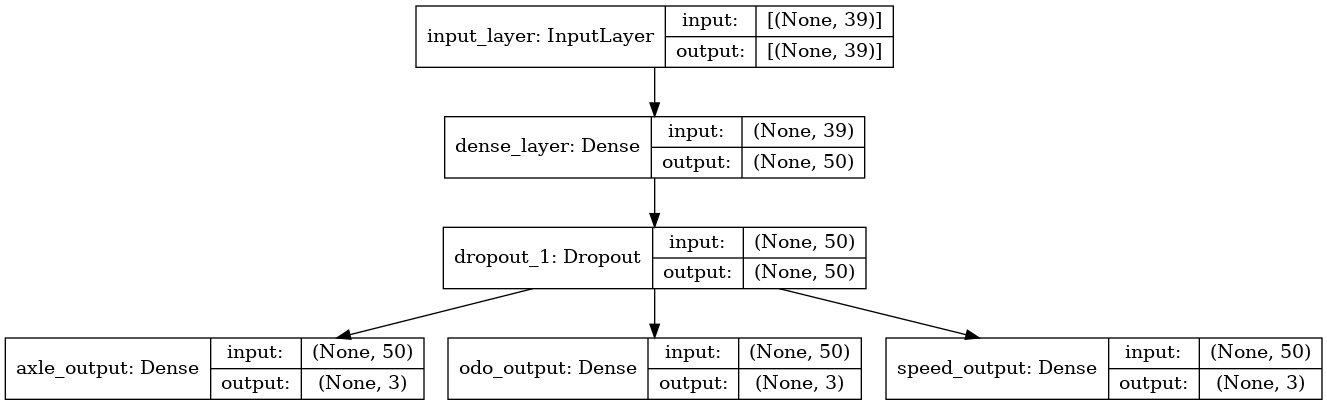

In [60]:
plot_model(model, show_shapes=True)

In [61]:
multioutput_target = [df_y[c].values for c in df_y.columns]

In [62]:
model.fit(x=df_X,
          y=multioutput_target,
          epochs=500,
          validation_split=0.3,
          verbose=0)

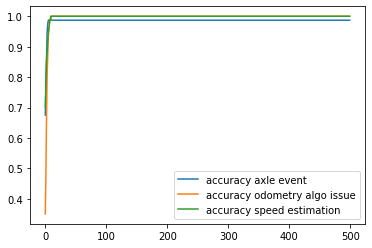

In [66]:
plt.figure()
plt.plot(model.history.history["val_axle_output_acc"], label="accuracy axle event")
plt.plot(model.history.history["val_odo_output_acc"], label="accuracy odometry algo issue")
plt.plot(model.history.history["val_speed_output_acc"], label="accuracy speed estimation")
# plt.ylim(0.9,1.01)
plt.legend()
plt.show()

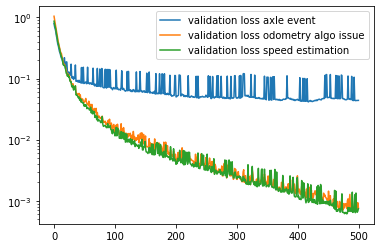

In [67]:
plt.figure()
plt.plot(model.history.history["val_axle_output_loss"], label="validation loss axle event")
plt.plot(model.history.history["val_odo_output_loss"], label="validation loss odometry algo issue")
plt.plot(model.history.history["val_speed_output_loss"], label="validation loss speed estimation")
plt.legend()
plt.semilogy()
plt.show()

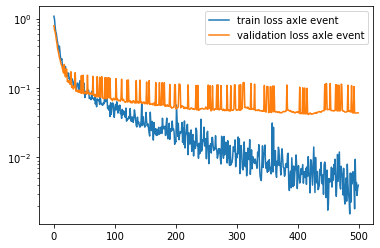

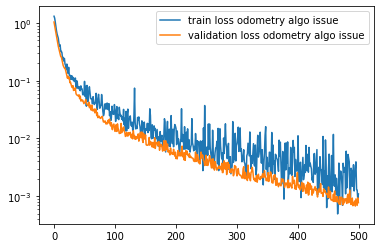

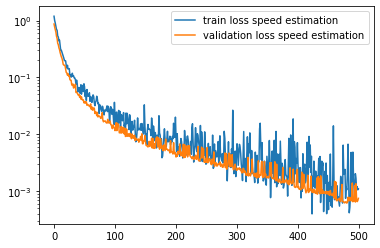

In [68]:
plt.figure()
plt.plot(model.history.history["axle_output_loss"], label="train loss axle event")
plt.plot(model.history.history["val_axle_output_loss"], label="validation loss axle event")
plt.legend()
plt.semilogy()
plt.show()


plt.figure()
plt.plot(model.history.history["odo_output_loss"], label="train loss odometry algo issue")
plt.plot(model.history.history["val_odo_output_loss"], label="validation loss odometry algo issue")
plt.legend()
plt.semilogy()
plt.show()


plt.figure()
plt.plot(model.history.history["speed_output_loss"], label="train loss speed estimation")
plt.plot(model.history.history["val_speed_output_loss"], label="validation loss speed estimation")
plt.legend()
plt.semilogy()
plt.show()




In [69]:
model.evaluate(x=df_X, y=multioutput_target)

256/256 [==============================] - 0s 67us/sample - loss: 0.0184 - axle_output_loss: 0.0175 - odo_output_loss: 4.7567e-04 - speed_output_loss: 4.1887e-04 - axle_output_acc: 0.9961 - odo_output_acc: 1.0000 - speed_output_acc: 1.0000


[0.01837046081891458,
 0.01747592,
 0.0004756672,
 0.00041887467,
 0.99609375,
 1.0,
 1.0]